In [190]:
%load_ext autoreload
%autoreload 2

from cnn import CNN
from dyn_cnn import DynCNN
from util import Util
from patch import Patch
from fixer import Fixer
from uglify import Uglify

import os
import mahotas as mh
import numpy as np
import time

from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [372]:
#
# viren's approach with our LARGER border_overlap
#   image prob merged_array dyn_obj dyn_bnd border_overlap
networks = []
networks.append(CNN('viren_7', 'patches_7th', ['image', 'prob', 'merged_array']))
networks.append(CNN('mine_7', 'patches_7th', ['image', 'prob', 'binary', 'border_overlap']))
networks.append(CNN('mine_large_7', 'patches_7th', ['image', 'prob', 'binary', 'larger_border_overlap']))
networks.append(CNN('mine_merged_7', 'patches_7th', ['image', 'prob', 'merged_array', 'border_overlap']))
networks.append(CNN('mine_merged_large_7', 'patches_7th', ['image', 'prob', 'merged_array', 'larger_border_overlap']))
networks.append(DynCNN('dyn_viren_7', 'patches_7th', ['image', 'prob', 'merged_array']))
networks.append(DynCNN('dyn_mine_7', 'patches_7th', ['image', 'prob', 'binary', 'border_overlap']))
networks.append(DynCNN('dyn_mine_large_7', 'patches_7th', ['image', 'prob', 'binary', 'larger_border_overlap']))
networks.append(DynCNN('dyn_mine_merged_7', 'patches_7th', ['image', 'prob', 'merged_array', 'border_overlap']))
networks.append(DynCNN('dyn_mine_merged_large_7', 'patches_7th', ['image', 'prob', 'merged_array', 'larger_border_overlap']))


Loading ['/Volumes/DATA1/split_cnn/patches_7th/viren_7/configuration.txt']
Loading /Volumes/DATA1/split_cnn/patches_7th/viren_7/network_350.p
Loading ['/Volumes/DATA1/split_cnn/patches_7th/mine_7/configuration.txt']
Loading /Volumes/DATA1/split_cnn/patches_7th/mine_7/network_255.p
Loading ['/Volumes/DATA1/split_cnn/patches_7th/mine_large_7/configuration.txt']
Loading /Volumes/DATA1/split_cnn/patches_7th/mine_large_7/network_270.p
Loading ['/Volumes/DATA1/split_cnn/patches_7th/mine_merged_7/configuration.txt']
Loading /Volumes/DATA1/split_cnn/patches_7th/mine_merged_7/network_251.p
Loading ['/Volumes/DATA1/split_cnn/patches_7th/mine_merged_large_7/configuration.txt']
Loading /Volumes/DATA1/split_cnn/patches_7th/mine_merged_large_7/network_262.p
Loading ['/Volumes/DATA1/split_cnn/patches_7th/dyn_viren_7/configuration.txt']
Loading /Volumes/DATA1/split_cnn/patches_7th/dyn_viren_7/network_202.p
Loading ['/Volumes/DATA1/split_cnn/patches_7th/dyn_mine_7/configuration.txt']
Loading /Volumes/D

In [196]:
input_image, input_prob, input_gold, input_rhoana, dojo_bbox = Util.read_dojo_data() 

In [374]:
DOJO_USER_DATA_FOLDER = '/Users/d/Dropbox/DOJOSTUDY/'
DOJO_USERS_IDS = [11,13,18,37,40,43,5,50,53,62]
DOJO_USERS = []
for d in DOJO_USERS_IDS:
    DOJO_USERS.append('S'+str(d)+'tif')
    
def read_user(user, slice):
    img = mh.imread(DOJO_USER_DATA_FOLDER+user+os.sep+'z='+str(slice).zfill(8)+'.tif')
    img = Util.crop_by_bbox(img, dojo_bbox)
    return Util.frame_image(img)

def dojo_user_vi(user, slice, gt):
    img = read_user(user, slice)
    return Util.vi(img, gt)

def fix_dojo_slice(cnn, slice, input_image, input_prob, input_rhoana, input_gold,t=0.):
    DOJO_SLICE=slice
    vi_s, merge_pairs, surenesses = Fixer.splits(cnn, 
                                                 input_image[DOJO_SLICE], 
                                                 input_prob[DOJO_SLICE], 
                                                 input_rhoana[DOJO_SLICE], 
                                                 input_gold[DOJO_SLICE],
                                                 sureness_threshold=t,
                                                 oversampling=False)

    best_index = vi_s.index(np.min(vi_s))
    best_vi = vi_s[best_index]
    best_sureness = surenesses[best_index]
    
    return best_vi, best_sureness, vi_s, surenesses

def fix_dojo_slice_user_simulated(cnn, slice, input_image, input_prob, input_rhoana, input_gold, error_rate=0,t=0):
    DOJO_SLICE=slice
    vi_s, merge_pairs, surenesses, good_fixes, bad_fixes = Fixer.splits_user_simulated(cnn, 
                                                 input_image[DOJO_SLICE], 
                                                 input_prob[DOJO_SLICE], 
                                                 input_rhoana[DOJO_SLICE], 
                                                 input_gold[DOJO_SLICE],
                                                 error_rate=error_rate,
                                                 sureness_threshold=t,                                                 
                                                 oversampling=False)
    
    best_index = vi_s.index(np.min(vi_s))
    best_vi = vi_s[best_index]
    best_sureness = surenesses[best_index]
    
    return best_vi, good_fixes, bad_fixes, merge_pairs, vi_s

def threed_vi(gt, seg):
    total_vi = 0
    slice_vi = []    
    for i in range(10):
        current_vi = Util.vi(gt[i].astype(np.int64), seg[i].astype(np.int64))
        total_vi += current_vi
        slice_vi.append(current_vi)
    total_vi /= 10
    return total_vi, slice_vi

def user_threed_vi(gt, user):
    total_vi = 0
    slice_vi = []
    for i in range(10):
        current_vi = dojo_user_vi(user, i, gt[i])
        total_vi += current_vi
        slice_vi.append(current_vi)
    total_vi /= 10
    return total_vi, slice_vi
    
def cnn_threed_vi(cnn, input_image, input_prob, input_rhoana, input_gold):
    total_vi = 0
    slice_vi = []
    slice_sureness = []
    for i in range(10):
        current_vi, sureness, vi_s, surenesses = fix_dojo_slice(cnn, i, input_image, input_prob, input_rhoana, input_gold)
        total_vi += current_vi
        slice_vi.append(current_vi)
        slice_sureness.append(sureness)
    total_vi /= 10
    return total_vi, slice_vi, slice_sureness
        

In [59]:
threed_vi(input_gold, input_rhoana)

0.5933600951369349

In [375]:
cnn_vi_s = []
cnn_slice_vi_s = []
cnn_surenesses = []
cnn_times = []
for n in networks:
    t0 = time.time()
    cnn_vi, slice_vis, slice_sureness = cnn_threed_vi(n, input_image, input_prob, input_rhoana, input_gold)
    cnn_vi_s.append(cnn_vi)
    cnn_slice_vi_s.append(slice_vis)
    cnn_surenesses.append(slice_sureness)
    cnn_times.append(time.time()-t0)
    

464 generated in 10.2443630695 seconds.
Grouped into 116 patches in 0.00300884246826 seconds.
Merge loop finished in 21.8421099186 seconds.
Before VI: 0.456495226471
Smallest VI: 0.42699863396
Sureness threshold: 0.989471077919
448 generated in 9.7436170578 seconds.
Grouped into 112 patches in 0.00296902656555 seconds.
Merge loop finished in 20.3260831833 seconds.
Before VI: 0.429392255747
Smallest VI: 0.410100319075
Sureness threshold: 0.972227990627
456 generated in 9.97493290901 seconds.
Grouped into 113 patches in 0.00296020507812 seconds.
Merge loop finished in 23.152736187 seconds.
Before VI: 0.418126257718
Smallest VI: 0.376229501303
Sureness threshold: 0.982091605663
484 generated in 10.3421471119 seconds.
Grouped into 121 patches in 0.00329899787903 seconds.
Merge loop finished in 22.1740260124 seconds.
Before VI: 0.417671556086
Smallest VI: 0.408266936423
Sureness threshold: 0.996026992798
508 generated in 10.8766770363 seconds.
Grouped into 127 patches in 0.00349712371826 se

In [271]:
np.mean(cnn_times)

369.01299064159394

In [267]:
np.mean(cnn_slice_vi_s[2])

0.49021509916746309

In [269]:
Util.stats(cnn_surenesses)

  N:  10
  Min:  0.67627286911
  Max:  0.998591244221
  Mean:  0.950593363643
  Median:  0.971555799246
  Std:  0.0614820470092
  Var:  0.00378004210444


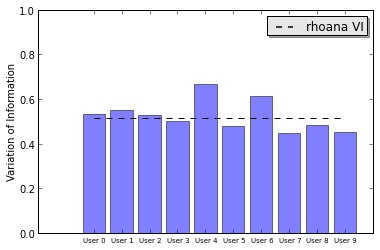

In [270]:

objects = []
performance = []
user_slice_vis = []
for i,d in enumerate(DOJO_USERS):
    objects.append('User '+ str(i))
    user_vi, slice_vis = user_threed_vi(input_gold, d)
    performance.append(user_vi)
    user_slice_vis.append(slice_vis)

before_vi, before_slice_vis = threed_vi(input_gold, input_rhoana)    

y_pos = np.arange(len(objects))    
    
fig, ax = plt.subplots()
ax.plot(range(0,10), [before_vi]*len(objects), 'k--', label='rhoana VI')
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
ax.tick_params(axis='x', labelsize=7)
ax.set_ylim(0,1.)

plt.ylabel('Variation of Information')

# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)

# The frame is matplotlib.patches.Rectangle instance surrounding the legend.
frame = legend.get_frame()
frame.set_facecolor('0.90')

# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')

for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width


In [204]:
performance[7]

0.44734259296152945

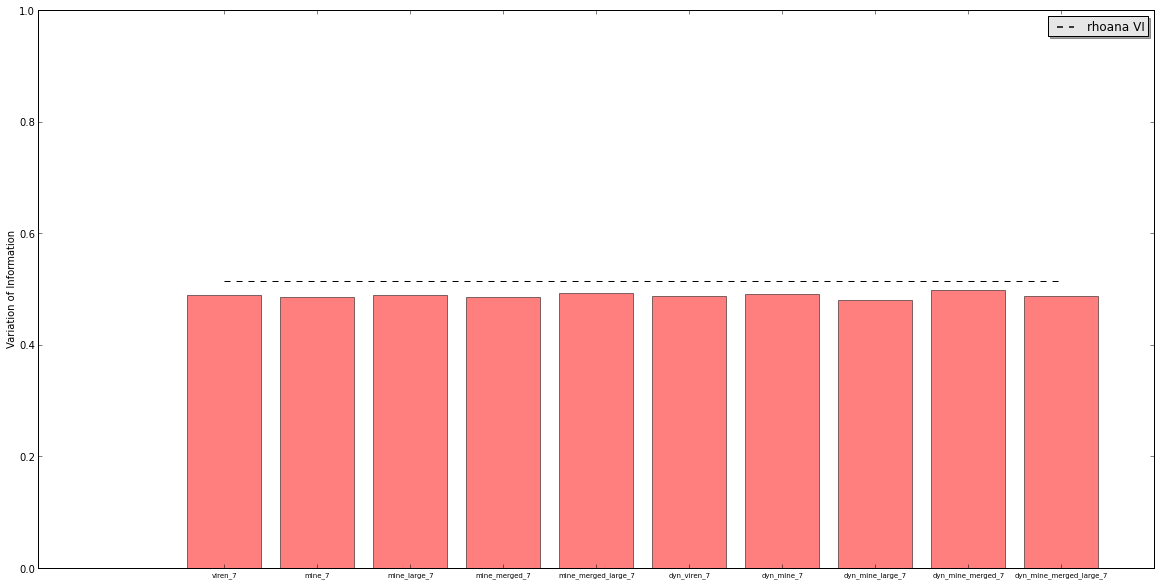

In [202]:
objects = []
performance = []
# user_slice_vis = []
for i,n in enumerate(networks):
    objects.append(n._NETWORK_ID)
#     user_vi, slice_vis = user_threed_vi(input_gold, d)
    performance.append(cnn_vi_s[i])
#     user_slice_vis.append(slice_vis)

before_vi, before_slice_vis = threed_vi(input_gold, input_rhoana)    

y_pos = np.arange(len(objects))    

fig, ax = plt.subplots(figsize=(20,10))
ax.plot(range(0,10), [before_vi]*len(objects), 'k--', label='rhoana VI')
plt.bar(y_pos, performance, align='center', alpha=0.5, color='red')
plt.xticks(y_pos, objects)
ax.tick_params(axis='x', labelsize=7)
ax.set_ylim(0,1.)
plt.ylabel('Variation of Information')

# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)

# The frame is matplotlib.patches.Rectangle instance surrounding the legend.
frame = legend.get_frame()
frame.set_facecolor('0.90')

# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')

for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width

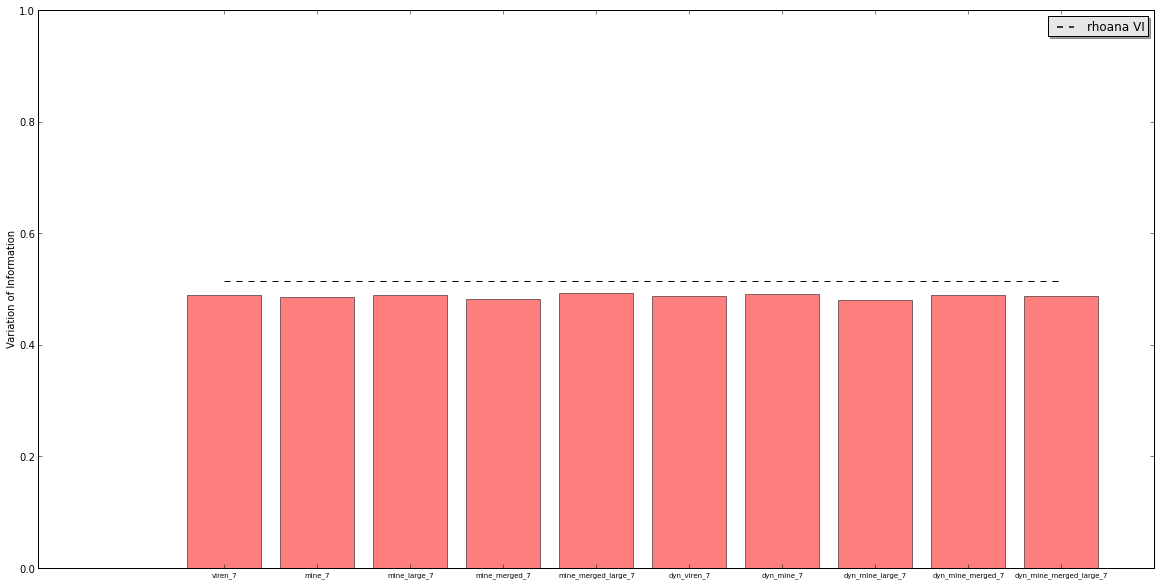

In [376]:
objects = []
performance = []
# user_slice_vis = []
for i,n in enumerate(networks):
    objects.append(n._NETWORK_ID)
#     user_vi, slice_vis = user_threed_vi(input_gold, d)
    performance.append(cnn_vi_s[i])
#     user_slice_vis.append(slice_vis)

before_vi, before_slice_vis = threed_vi(input_gold, input_rhoana)    

y_pos = np.arange(len(objects))    

fig, ax = plt.subplots(figsize=(20,10))
ax.plot(range(0,10), [before_vi]*len(objects), 'k--', label='rhoana VI')
plt.bar(y_pos, performance, align='center', alpha=0.5, color='red')
plt.xticks(y_pos, objects)
ax.tick_params(axis='x', labelsize=7)
ax.set_ylim(0,1.)
plt.ylabel('Variation of Information')

# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)

# The frame is matplotlib.patches.Rectangle instance surrounding the legend.
frame = legend.get_frame()
frame.set_facecolor('0.90')

# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')

for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width

In [370]:
simulated_user_er_vi_s =[]
for er in range(0,10,1):
    
    er = er/100.
    
    simulated_user_vi_s2 = []
    for i in range(0,10):
        best_vi, good_fixes, bad_fixes, merge_pairs, vi_s  = fix_dojo_slice_user_simulated(networks[2],i, input_image, input_prob, input_rhoana,input_gold, error_rate=er)
        simulated_user_vi_s2.append(vi_s[-1])

    simulated_user_er_vi_s.append(np.mean(simulated_user_vi_s2))

464 generated in 10.3019490242 seconds.
Grouped into 116 patches in 0.00304007530212 seconds.
Start M 232
Merge loop finished in 4.79426503181 seconds.
Before VI: 0.456495226471
Smallest VI: 0.390161631168
Sureness threshold: 0.038141194731
448 generated in 9.72103404999 seconds.
Grouped into 112 patches in 0.00292706489563 seconds.
Start M 224
Merge loop finished in 4.76122093201 seconds.
Before VI: 0.429392255747
Smallest VI: 0.378655213857
Sureness threshold: 0.272963374853
456 generated in 10.0170471668 seconds.
Grouped into 113 patches in 0.00299596786499 seconds.
Start M 226
Merge loop finished in 4.83807992935 seconds.
Before VI: 0.418126257718
Smallest VI: 0.363588739313
Sureness threshold: 0.0634429380298
484 generated in 10.3679888248 seconds.
Grouped into 121 patches in 0.00351405143738 seconds.
Start M 242
Merge loop finished in 6.27748703957 seconds.
Before VI: 0.417671556086
Smallest VI: 0.343845013422
Sureness threshold: 0.305156320333
508 generated in 11.0688490868 seco

In [371]:
simulated_user_er_vi_s

[0.39417157822328769,
 0.44262754641950181,
 0.43724463773450906,
 0.48556718867826865,
 0.50630356217978378,
 0.55273909257832943,
 0.63664689837735555,
 0.67180684794910195,
 0.69650814514403092,
 0.94271129915217666]

In [360]:
best_vi, good_fixes, bad_fixes, merge_pairs, vi_s  = fix_dojo_slice_user_simulated(networks[7],0, input_image, input_prob, input_rhoana,input_gold, error_rate=.8, t=.95)

464 generated in 10.1940250397 seconds.
Grouped into 116 patches in 0.00290608406067 seconds.
Start M 232
user err
user err
user err
user err
user err
user err
user err
user err
user err
user err
Merge loop finished in 0.948987007141 seconds.
Before VI: 0.456495226471
Smallest VI: 0.456933935471
Sureness threshold: 0.951163232327


In [362]:
vi_s[-1]

0.45958162558164073

In [195]:
t0 = time.time()
simulated_user_vi_s = []
good_fixes = []
bad_fixes = []
for i in range(0,10):
    simulated_user_vi, gf, bf,mps,vi_s  = fix_dojo_slice_user_simulated(networks[7],i, input_image, input_prob, input_rhoana,input_gold, error_rate=0.)
    simulated_user_vi_s.append(simulated_user_vi)
    good_fixes.append(gf)
    bad_fixes.append(bf)

print np.mean(simulated_user_vi_s)
print 'ran in',time.time()-t0,'seconds'

464 generated in 10.2098720074 seconds.
Grouped into 116 patches in 0.00295400619507 seconds.
Start M 232
Merge loop finished in 4.7006149292 seconds.
Before VI: 0.507538577929
Smallest VI: 0.441898092166
Sureness threshold: 0.488598167896
448 generated in 9.58975195885 seconds.
Grouped into 112 patches in 0.00292778015137 seconds.
Start M 224
Merge loop finished in 4.75685596466 seconds.
Before VI: 0.490232307552
Smallest VI: 0.444150160444
Sureness threshold: 0.333336651325


KeyboardInterrupt: 

In [365]:
print 'avg. good fixes', np.mean(good_fixes)
print 'avg. bad fixes', np.mean(bad_fixes)

avg. good fixes 18.0
avg. bad fixes 63.0


In [117]:
Util.stats(good_fixes)

  N:  10
  Min:  10
  Max:  23
  Mean:  16.7
  Median:  16.5
  Std:  3.52278299076
  Var:  12.41


In [118]:
Util.stats(bad_fixes)

  N:  10
  Min:  14
  Max:  18
  Mean:  16.0
  Median:  16.0
  Std:  1.18321595662
  Var:  1.4


In [205]:
simulated_user_vi, gf, bf,mps, vi_s  = fix_dojo_slice_user_simulated(networks[7],0, input_image, input_prob, input_rhoana,input_gold, error_rate=0.)
simulated_user_vi_s.append(simulated_user_vi)


464 generated in 10.2087979317 seconds.
Grouped into 116 patches in 0.00308203697205 seconds.
Start M 232
Merge loop finished in 4.63332414627 seconds.
Before VI: 0.456495226471
Smallest VI: 0.390161631168
Sureness threshold: 0.488598167896


In [377]:
np.mean(bf)

115.0

In [378]:
np.mean(gf)

16.0

In [211]:
automatic_vi = fix_dojo_slice(networks[7],0, input_image, input_prob, input_rhoana,input_gold)

464 generated in 10.2176311016 seconds.
Grouped into 116 patches in 0.00299787521362 seconds.
Merge loop finished in 20.6096220016 seconds.
Before VI: 0.456495226471
Smallest VI: 0.431905708322
Sureness threshold: 0.968341290951


In [380]:
(121*15)/60

30

In [314]:
#
# this creates the top bins for the best five merge splits but also simulates the user who picks the best
#
#


t0 = time.time()
fixed_volume = np.array(input_rhoana)

top_bins = [0,0,0,0,0]
top_bins_counter = [0,0,0,0,0]


for i in range(0,10):
    print 'working on slice', i
    
    DOJO_SLICE = i

    pred_best_per_slice = []
    results_best_per_slice = []
    
    hist = Util.get_histogram(input_rhoana[DOJO_SLICE].astype(np.uint64))
    labels = range(len(hist))
    # np.random.shuffle(labels)
    THRESHOLD = .5

    slice_vi_diffs = []
    split_errors = {}

    fixed_slice = np.array(input_rhoana[DOJO_SLICE], dtype=np.uint64)

    for l in labels:

        if l == 0 or hist[l]<3000:
#             print l, hist[l]
            continue

#         print l

        before_merge_error = np.zeros(input_rhoana[DOJO_SLICE].shape)
        before_merge_error[fixed_slice == l] = 1
    #     Util.view_labels(input_rhoana[0], l)
    #     before_merge_error = mh.croptobbox(before_merge_error)


        borders, best_border_image, result, result_no_border, results_no_border, predictions = Fixer.fix_single_merge(networks[7],
                                                                                                                      input_image[DOJO_SLICE],
                                                                                                                      input_prob[DOJO_SLICE],
                                                                                                                      before_merge_error, N=30, 
                                                                                                                      erode=True, 
                                                                                                                      invert=True,
                                                                                                                      dilate=True,
                                                                                                                      border_seeds=True,
                                                                                                                      oversampling=False)



        if len(predictions) > 0:
            
            #
            # SORT THE PREDICTIONS
            # LOOK AT TOP 5
            # CHOOSE THE ONE WITH THE BEST VI
            sorted_pred = sorted(zip(results_no_border, predictions), key=lambda x: x[1])

            vi_before_merge = Util.vi(fixed_slice.astype(np.int64), input_gold[DOJO_SLICE].astype(np.int64))
            best_vi_after_merge = vi_before_merge
            best_possible_result = np.array(fixed_slice)
#             possible_results = []
            
            for pred in range(5):
                
                if pred >= len(sorted_pred):
                    continue
                    
                if sorted_pred[pred][1] >= THRESHOLD:
                    print sorted_pred[pred][1]
                    continue


                
                slice_copy = np.array(fixed_slice, dtype=np.int64)
                
                current_result = sorted_pred[pred][0]
                
                current_result[current_result != 0] += fixed_slice.max()

                slice_copy += current_result.astype(np.int64)

                sizes = mh.labeled.labeled_size(slice_copy)
                too_small = np.where(sizes < 200)
                labeled_small = mh.labeled.remove_regions(slice_copy, too_small)
                labeled_small_zeros = Util.threshold(labeled_small, 0)
                labeled_small = Util.fill(labeled_small, labeled_small_zeros.astype(np.bool))
                slice_copy = Util.frame_image(labeled_small).astype(np.uint64)          

#                 if pred==0:
#                     pred_best_per_slice.append(sorted_pred[0])
#                     results_best_per_slice.append(slice_copy)                
                
                # NOW WE CHECK FOR THE VI
                vi_after_merge = Util.vi(slice_copy.astype(np.int64), input_rhoana[DOJO_SLICE].astype(np.int64))
                
                if vi_after_merge < best_vi_after_merge:
                    # this improves
                    print 'new vi after merge fix', vi_after_merge, sorted_pred[pred][1]
#                     possible_results.append(slice_copy)
                    best_possible_result = np.array(slice_copy, dtype=np.int64)
                    best_vi_after_merge = vi_after_merge
            
                    vi_diff = vi_before_merge - vi_after_merge
                    if vi_diff > 0:
                        top_bins[pred] += vi_diff
                        for j in range(pred,5):
                            top_bins[j] += vi_diff
                            top_bins_counter[j] += 1            
            
                else:
                    # reject it
                    best_possible_result = np.array(fixed_slice, dtype=np.int64)
            

                        
            
            fixed_slice = best_possible_result
            
# #             print l, predictions
#             lowest_prediction_index = predictions.index(min(predictions))
#             lowest_prediction = predictions[lowest_prediction_index]

#             if lowest_prediction < THRESHOLD:

#                 print 'Found merge error', lowest_prediction, l

#                 result[result != 0] += fixed_slice.max()

#                 fixed_slice += result.astype(np.uint64)

#     #             split_errors[str(l)] = result

    
    fixed_volume[i] = fixed_slice


for i in range(5):
    
    top_bins[i] /= top_bins_counter[i]
    
print 'merge error correction done after',time.time()-t0, 'seconds'




working on slice 0
0.928759396076
0.928759396076
0.993708968163
0.993708968163
0.993708968163
0.997002661228
0.972538411617
0.984108567238
0.986369132996
0.986369132996
0.986369132996
new vi after merge fix 0.0565973000008 0.385964632034
0.955352246761
0.967351734638
0.967351734638
0.98349660635
0.98349660635
working on slice 1
0.891268610954
0.891268610954
0.891268610954
0.891268610954
0.891268610954
new vi after merge fix 0.0454961062389 0.488413929939
0.961799263954
0.974876642227
0.974876642227
0.974876642227
0.974876642227
0.974876642227
0.529033362865
0.529033362865
0.529033362865
0.529033362865
0.529033362865
0.989430010319
0.989430010319
0.989430010319
0.989430010319
0.989430010319
working on slice 2
0.843024134636
0.843024134636
0.843024134636
0.843024134636
0.843024134636
0.987919688225
0.987919688225
0.987919688225
0.987919688225
0.987919688225
0.96632194519
0.983550310135
0.983550310135
0.983550310135
0.983550310135
0.96381688118
0.96381688118
0.96381688118
0.96381688118
0.

In [240]:
Util.vi(input_gold[0], input_rhoana[0])

0.4564952264711417

In [316]:
Util.vi(input_gold[0].astype(np.int64), fixed_volume[0].astype(np.int64))

0.4300420889106302

In [318]:
top_bins

[0.977004167762165,
 0.4885020838810825,
 0.4885020838810825,
 0.5897963788878401,
 0.5042562253929554]

In [315]:
#
# test with user in the loop after merge correction
#
t0 = time.time()
simulated_user_vi_s = []
good_fixes = []
bad_fixes = []
for i in range(0,10):
    simulated_user_vi, gf, bf,mps,vi_s  = fix_dojo_slice_user_simulated(networks[7],i, input_image, input_prob, input_rhoana,input_gold, error_rate=0.)
    simulated_user_vi_s.append(simulated_user_vi)
    good_fixes.append(gf)
    bad_fixes.append(bf)

print np.mean(simulated_user_vi_s)
print 'ran in',time.time()-t0,'seconds'

464 generated in 10.2049849033 seconds.
Grouped into 116 patches in 0.00295996665955 seconds.
Start M 232
Merge loop finished in 4.64622402191 seconds.
Before VI: 0.456495226471
Smallest VI: 0.390161631168
Sureness threshold: 0.488598167896
448 generated in 9.82217097282 seconds.
Grouped into 112 patches in 0.00290298461914 seconds.
Start M 224
Merge loop finished in 5.05374312401 seconds.
Before VI: 0.429392255747
Smallest VI: 0.378655213857
Sureness threshold: 0.333336651325
456 generated in 10.1591129303 seconds.
Grouped into 113 patches in 0.00297808647156 seconds.
Start M 226
Merge loop finished in 4.84043502808 seconds.
Before VI: 0.418126257718
Smallest VI: 0.364915058683
Sureness threshold: 0.0781380087137
484 generated in 10.5750179291 seconds.
Grouped into 121 patches in 0.00321412086487 seconds.
Start M 242
Merge loop finished in 6.6533229351 seconds.
Before VI: 0.417671556086
Smallest VI: 0.343845013422
Sureness threshold: 0.145584478974
508 generated in 11.032738924 second

In [317]:
simulated_user_vi_s

[0.3901616311678895,
 0.37865521385721834,
 0.3649150586826,
 0.34384501342222507,
 0.3887227169421976,
 0.3703256924298932,
 0.4262203882999849,
 0.45957329825904836,
 0.4302968615194871,
 0.390326227022304]

In [343]:
t0 = time.time()
#
# test with
#
slice_vi_s_auto = []
for i in range(10):
    best_vi, best_sureness, vi_s, surenesses = fix_dojo_slice(networks[7],i, input_image, input_prob, fixed_volume2,input_gold,t=.95)
    slice_vi_s_auto.append(vi_s[-1])
    print 'VI @ t', vi_s[-1]
print time.time()-t0

464 generated in 10.2037439346 seconds.
Grouped into 116 patches in 0.00293684005737 seconds.
Merge loop finished in 1.87838697433 seconds.
Before VI: 0.430042088911
Smallest VI: 0.405329725841
Sureness threshold: 0.968341290951
VI @ t 0.418450933374
432 generated in 9.25866103172 seconds.
Grouped into 108 patches in 0.0028178691864 seconds.
Merge loop finished in 1.33308196068 seconds.
Before VI: 0.426770725022
Smallest VI: 0.392124874235
Sureness threshold: 0.9707275033
VI @ t 0.392124874235
456 generated in 9.85781979561 seconds.
Grouped into 113 patches in 0.00292992591858 seconds.
Merge loop finished in 1.11818218231 seconds.
Before VI: 0.418126257718
Smallest VI: 0.405170577155
Sureness threshold: 0.961898028851
VI @ t 0.424757985754
484 generated in 10.3093411922 seconds.
Grouped into 121 patches in 0.00324106216431 seconds.
Merge loop finished in 1.54223895073 seconds.
Before VI: 0.417671556086
Smallest VI: 0.410773226391
Sureness threshold: 0.992599964142
VI @ t 0.421609118042

In [344]:
#
# test with
#
t0 = time.time()
slice_vi_s_auto_r = []
for i in range(10):
    best_vi, best_sureness, vi_s, surenesses = fix_dojo_slice(networks[7],i, input_image, input_prob, input_rhoana,input_gold,t=.95)
    slice_vi_s_auto_r.append(vi_s[-1])
    print 'VI @ t', vi_s[-1]
print time.time()-t0

464 generated in 10.2446529865 seconds.
Grouped into 116 patches in 0.00295090675354 seconds.
Merge loop finished in 1.87912011147 seconds.
Before VI: 0.456495226471
Smallest VI: 0.431905708322
Sureness threshold: 0.968341290951
VI @ t 0.444961690458
448 generated in 9.60497283936 seconds.
Grouped into 112 patches in 0.00294995307922 seconds.
Merge loop finished in 1.34076094627 seconds.
Before VI: 0.429392255747
Smallest VI: 0.394909591297
Sureness threshold: 0.9707275033
VI @ t 0.394909591297
456 generated in 9.86333918571 seconds.
Grouped into 113 patches in 0.00302982330322 seconds.
Merge loop finished in 1.1138420105 seconds.
Before VI: 0.418126257718
Smallest VI: 0.405170577155
Sureness threshold: 0.961898028851
VI @ t 0.424757985754
484 generated in 10.1970169544 seconds.
Grouped into 121 patches in 0.00322198867798 seconds.
Merge loop finished in 1.5142531395 seconds.
Before VI: 0.417671556086
Smallest VI: 0.410773226391
Sureness threshold: 0.992599964142
VI @ t 0.421609118042


In [342]:
slice_vi_s_auto

[0.4184509333743103,
 0.3921248742351109,
 0.42475798575369517,
 0.42160911804209533,
 0.42020309533028843,
 0.4227406441289636,
 0.5567583337051563,
 0.6766219832111187,
 0.6145879465212047,
 0.6214100098652011]

In [322]:
#
# GREEDY
#
#


t0 = time.time()
fixed_volume2 = np.array(input_rhoana)

top_bins = [0,0,0,0,0]
top_bins_counter = [0,0,0,0,0]


for i in range(0,10):
    print 'working on slice', i
    
    DOJO_SLICE = i

    pred_best_per_slice = []
    results_best_per_slice = []
    
    hist = Util.get_histogram(input_rhoana[DOJO_SLICE].astype(np.uint64))
    labels = range(len(hist))
    # np.random.shuffle(labels)
    THRESHOLD = .5

    slice_vi_diffs = []
    split_errors = {}

    fixed_slice = np.array(input_rhoana[DOJO_SLICE], dtype=np.uint64)

    for l in labels:

        if l == 0 or hist[l]<3000:
#             print l, hist[l]
            continue

#         print l

        before_merge_error = np.zeros(input_rhoana[DOJO_SLICE].shape)
        before_merge_error[fixed_slice == l] = 1
    #     Util.view_labels(input_rhoana[0], l)
    #     before_merge_error = mh.croptobbox(before_merge_error)


        borders, best_border_image, result, result_no_border, results_no_border, predictions = Fixer.fix_single_merge(networks[7],
                                                                                                                      input_image[DOJO_SLICE],
                                                                                                                      input_prob[DOJO_SLICE],
                                                                                                                      before_merge_error, N=30, 
                                                                                                                      erode=True, 
                                                                                                                      invert=True,
                                                                                                                      dilate=True,
                                                                                                                      border_seeds=True,
                                                                                                                      oversampling=False)



        if len(predictions) > 0:
#             vi_before_merge = Util.vi(fixed_slice.astype(np.int64), input_gold[DOJO_SLICE].astype(np.int64))
            #
            # TAKE ONLY THE FIRST BEST RESULT
            sorted_pred = sorted(zip(results_no_border, predictions), key=lambda x: x[1])
            
            if sorted_pred[0][1] > THRESHOLD:
                continue
                
            print 'correcting ', l, 'w/', sorted_pred[0][1]
                
            
            slice_copy = np.array(fixed_slice, dtype=np.int64)

            current_result = sorted_pred[0][0]

            current_result[current_result != 0] += fixed_slice.max()

            slice_copy += current_result.astype(np.int64)            
            
            sizes = mh.labeled.labeled_size(slice_copy)
            too_small = np.where(sizes < 200)
            labeled_small = mh.labeled.remove_regions(slice_copy, too_small)
            labeled_small_zeros = Util.threshold(labeled_small, 0)
            labeled_small = Util.fill(labeled_small, labeled_small_zeros.astype(np.bool))
            slice_copy = Util.frame_image(labeled_small).astype(np.uint64)          

#             vi_after_merge = Util.vi(slice_copy.astype(np.int64), input_rhoana[DOJO_SLICE].astype(np.int64))
            
#             for i in range(5):
#                 vi_diff = vi_before_merge - vi_after_merge
#                 print vi_diff
#                 if vi_diff > 0:
#                     top_bins[pred] += vi_diff
#                     for j in range(pred,5):
#                         top_bins[j] += vi_diff
#                         top_bins_counter[j] += 1     
            
            fixed_slice = slice_copy
            
# #             print l, predictions
#             lowest_prediction_index = predictions.index(min(predictions))
#             lowest_prediction = predictions[lowest_prediction_index]

#             if lowest_prediction < THRESHOLD:

#                 print 'Found merge error', lowest_prediction, l

#                 result[result != 0] += fixed_slice.max()

#                 fixed_slice += result.astype(np.uint64)

#     #             split_errors[str(l)] = result

    
    fixed_volume2[i] = fixed_slice


# for i in range(5):
    
#     top_bins[i] /= top_bins_counter[i]
    
print 'merge error correction done after',time.time()-t0, 'seconds'




working on slice 0
correcting  40 w/ 0.385964632034
working on slice 1
correcting  32 w/ 0.488413929939
working on slice 2
working on slice 3
working on slice 4
correcting  31 w/ 0.289200842381
working on slice 5
working on slice 6
working on slice 7
working on slice 8
correcting  58 w/ 0.381048887968
correcting  71 w/ 0.215496644378
working on slice 9
correcting  77 w/ 0.0309201385826
merge error correction done after 912.851178169 seconds


In [323]:
user_slice_vis

[[0.5446643065403123,
  0.5202083942196767,
  0.4487308416799145,
  0.5256271499720278,
  0.6017310095955679,
  0.5635849827171002,
  0.48208509251280507,
  0.49196247461004017,
  0.5482387161546605,
  0.5964249941272648],
 [0.49000138123615766,
  0.4042343782110773,
  0.5004854457403498,
  0.4266450421850685,
  0.5568891385529584,
  0.5148034680512126,
  0.6462890723019648,
  0.6613813533553348,
  0.6671288321276032,
  0.6538467069160925],
 [0.4998991662113408,
  0.442935961872414,
  0.4259722670367694,
  0.46123023510716,
  0.5022720899614148,
  0.4712287225498315,
  0.5580440641754336,
  0.5692840892112363,
  0.6690348890513427,
  0.6785597959903917],
 [0.39836869720195267,
  0.3709202507302969,
  0.40338011648347916,
  0.427082479108539,
  0.5017147063663963,
  0.48204760368070065,
  0.5898171380080761,
  0.6002397803838102,
  0.6237553737595674,
  0.6145256350294899],
 [0.6515874676516002,
  0.6444184225192346,
  0.6523659531181139,
  0.661813262141079,
  0.7314962749548775,
  0.7

In [337]:
slice_vi_user_avg=[0]*10
for u in user_slice_vis:


    for s in range(0,10):

        slice_vi_user_avg[s] += u[s]
        
for s in range(0,10):
    slice_vi_user_avg[s] /= 10

In [325]:
user_slice_vis[7]

[0.376404316570806,
 0.3516472472473051,
 0.4079547444039404,
 0.45303068544352687,
 0.4894595570074438,
 0.47837141980718023,
 0.469179784610529,
 0.4852945056599962,
 0.49897197205284005,
 0.46311169681172704]

In [338]:
slice_vi_user_avg

[0.4731860793604075,
 0.44121438461816204,
 0.46451026029563797,
 0.47903279861401,
 0.5483534853137099,
 0.5209529752713282,
 0.5614397773390244,
 0.5669964497903159,
 0.6037881064187078,
 0.5986637472443784]